# Traffic signs detection project #
Section 1: extracting features and using them on 3 models.

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

path_base = os.getcwd() + "\\databases"
train, test = np.load(os.path.join(path_base,'train.npy')), np.load(os.path.join(path_base,'test.npy'))

In [2]:
# Change array of pictures of size 45x45 to array of pictures 45*45=2025:
x1 = train
x1 = x1.astype("float32") / 255
rows, cols = (4170, 2025)
X_train = np.array([[0]*cols]*rows)
X_train = X_train.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            X_train[i][jump] = x1[i][j][k]
            jump = jump + 1
    jump = 0


x2 = test
x2 = x2.astype("float32") / 255
rows, cols = (1994, 2025)
X_test = np.array([[0]*cols]*rows)
X_test = X_test.astype("float32")
jump = 0
for i in range(0,rows):
    for j in range(0, 45):
        for k in range(0, 45):
            X_test[i][jump] = x2[i][j][k]
            jump = jump + 1
    jump = 0

In [3]:
#get classification from file
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTrain4170Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Train_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Train_classes.append(i)

#get classification from file
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTest1994Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Test_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Test_classes.append(i)


In [4]:
# Use PCA and LDA:
pca = PCA(n_components=5)
x_pca_train = pca.fit_transform(X_train)
x_pca_test = pca.transform(X_test)
print(pca.explained_variance_ratio_)
print(x_pca_train[0])

lda = LinearDiscriminantAnalysis(n_components=8)
x_lda_train = lda.fit_transform(X_train,Train_classes)
x_lda_test = lda.transform(X_test)
print(lda.explained_variance_ratio_)
print(x_lda_train[0])

[0.35552633 0.12684065 0.0378055  0.03497336 0.03074877]
[-0.63589215  2.028263    1.1582127  -0.7553635   0.21937564]
[0.10739452 0.07403844 0.067053   0.06406805 0.05691917 0.04037642
 0.03603817 0.03408726]
[11.0772222  -3.23233705 12.68839913 -5.73308992 14.01431207 -2.27703305
  3.21618278 -2.30068937]


In [5]:
# Use RF model:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

clf1 = RandomForestClassifier(max_depth=10, random_state=0)
clf2 = RandomForestClassifier(max_depth=7, random_state=0)
clf1.fit(x_pca_train, Train_classes)
clf2.fit(x_lda_train, Train_classes)

print(clf1.predict(x_pca_test))
print(clf1.score(x_pca_test, Test_classes))
print(clf2.predict(x_lda_test))
print(clf2.score(x_lda_test, Test_classes))

[54  0  0 ... 57 57 57]
0.16649949849548645
[16 55 56 ... 57 57 57]
0.2086258776328987


In [6]:
#Print learning RF curves (PCA V.S LDA):

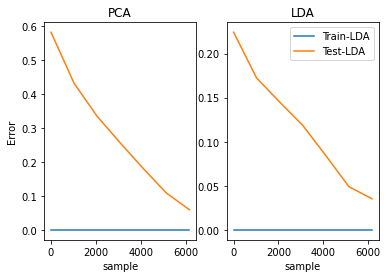

In [22]:
curveSize = 7 # Decide the length of the curves.
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = (train_test_split(np.append(x_pca_train, x_pca_test, axis=0), np.append(Train_classes, 
                Test_classes, axis=0),train_size=(i/(curveSize+1)))) 
    clf1.fit(X_train, y_train)
    y_predict = clf1.predict(X_train)
    trainErr_PCA.append(1-accuracy_score(y_train, y_predict))
    y_predict = clf1.predict(X_test)
    testErr_PCA.append(1-accuracy_score(y_test, y_predict))

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = (train_test_split(np.append(x_lda_train, x_lda_test, axis=0), np.append(Train_classes, 
                    Test_classes, axis=0), train_size=(i/(curveSize+1)))) 

    clf2.fit(X_train, y_train)
    y_predict = clf2.predict(X_train)
    trainErr_LDA.append(1-accuracy_score(y_train, y_predict))
    y_predict = clf2.predict(X_test)
    testErr_LDA.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(0, 6164, curveSize) 
y1 = np.polyfit(x, trainErr_PCA, 4)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 4)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 4) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 4)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("Error")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p4(x), label="Test-LDA")
plt.title("LDA")
plt.xlabel("sample")

plt.legend(loc="best") 
plt.show()



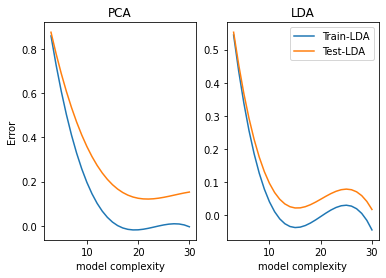

In [8]:
#model complexibility RF PCA/LDA

errors_in_train_pca = []
errors_in_test_pca = []
errors_in_train_lda = []
errors_in_test_lda = []
x_train, x_test, y_train, y_test = train_test_split(np.append(x_pca_train,x_pca_test, axis=0), 
                                                            np.append(Train_classes,Test_classes, axis=0))
x = np.linspace(3, 30, 28)
for i in range(3,31):
    clf1 = RandomForestClassifier(max_depth=i, class_weight = {0:1,1:2})
    clf1.fit(x_train, y_train)
    y_pred = clf1.predict(x_train)
    errors_in_train_pca.append(1-accuracy_score(y_train, y_pred))
    y_pred = clf1.predict(x_test)
    errors_in_test_pca.append(1-accuracy_score(y_test, y_pred))
    
x_train, x_test, y_train, y_test = train_test_split(np.append(x_lda_train,x_lda_test, axis=0), 
                                                            np.append(Train_classes,Test_classes, axis=0))
for i in range(3,31):
    clf2 = RandomForestClassifier(max_depth=i, class_weight = {0:1,1:2})
    clf2.fit(x_train, y_train)
    y_pred = clf2.predict(x_train)
    errors_in_train_lda.append(1-accuracy_score(y_train, y_pred))
    y_pred = clf2.predict(x_test)
    errors_in_test_lda.append(1-accuracy_score(y_test, y_pred))
 
y1 = np.polyfit(x, errors_in_train_pca, 3)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, errors_in_test_pca, 3)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, errors_in_train_lda, 3)
p3 = np.poly1d(y3)
y4 = np.polyfit(x, errors_in_test_lda, 3)
p4 = np.poly1d(y4)


plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")
plt.title("PCA")
plt.xlabel("model complexity")
plt.ylabel("Error")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p4(x), label="Test-LDA")
plt.title("LDA")
plt.xlabel("model complexity")

plt.legend(loc="best") 
plt.show()



In [9]:
# Use SVM model:
from sklearn import svm

svc1 = svm.SVC(kernel='rbf')
svc2 = svm.SVC(kernel='rbf')
svc1.fit(x_pca_train, Train_classes)
svc2.fit(x_lda_train, Train_classes)
print(svc1.predict(x_pca_test))
print(svc1.score(x_pca_test, Test_classes))
print(svc2.predict(x_lda_test))
print(svc2.score(x_lda_test, Test_classes))

[55 17  0 ... 57 57 57]
0.1123370110330993
[24  0 33 ... 57 57 57]
0.20060180541624875


In [10]:
#Print learning SVM curves (PCA V.S LDA):

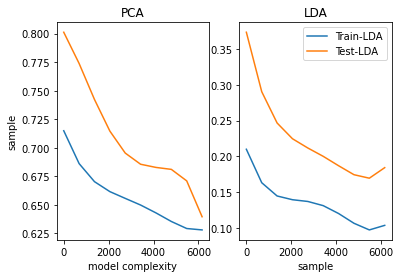

In [19]:
curveSize = 10 # Decide the length of the curves.
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []


for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = (train_test_split(np.append(x_pca_train, x_pca_test, axis=0), np.append(Train_classes, 
            Test_classes, axis=0),train_size=(i/(curveSize+1))))
    # Append more samples until we get all of them. train_size devides the samples according to the loop variable (curveSize+1).    
    svc1.fit(X_train, y_train)
    y_predict = svc1.predict(X_train)
    trainErr_PCA.append(1-accuracy_score(y_train, y_predict))
    y_predict = svc1.predict(X_test)
    testErr_PCA.append(1-accuracy_score(y_test, y_predict))

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = (train_test_split(np.append(x_lda_train, x_lda_test, axis=0), np.append(Train_classes, 
               Test_classes, axis=0), train_size=(i/(curveSize+1)))) 
    svc2.fit(X_train, y_train)
    y_predict = svc2.predict(X_train)
    trainErr_LDA.append(1-accuracy_score(y_train, y_predict))
    y_predict = svc2.predict(X_test)
    testErr_LDA.append(1-accuracy_score(y_test, y_predict))


plt.xlabel("Samples")
plt.ylabel("Error")

x = np.linspace(0, 6164, curveSize) 
y1 = np.polyfit(x, trainErr_PCA, 4)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 4)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 4) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 4)
p4 = np.poly1d(y4)

plt.subplot(1, 2, 1)
plt.plot(x, p1(x))
plt.plot(x, p2(x))
plt.title("PCA")
plt.xlabel("sample")
plt.ylabel("sample")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train")
plt.plot(x, p4(x), label="Test")
plt.title("LDA")
plt.xlabel("sample")

plt.legend(loc="best") 
plt.show()


In [ ]:
#model complexibility SVM PCA/LDA
#need to change

errors_in_train_pca = []
errors_in_test_pca = []
errors_in_train_lda = []
errors_in_test_lda = []
x_train, x_test, y_train, y_test = train_test_split(np.append(x_pca_train,x_pca_test, axis=0), 
                                                            np.append(Train_classes,Test_classes, axis=0))
x = np.linspace(3, 30, 28)
for i in range(3,31):
    svm1 = svm.SVC(kernel='rbf')
    svm1.fit(x_train, y_train)
    y_pred = svm1.predict(x_train)
    errors_in_train_pca.append(1-accuracy_score(y_train, y_pred))
    y_pred = svm1.predict(x_test)
    errors_in_test_pca.append(1-accuracy_score(y_test, y_pred))
    
x_train, x_test, y_train, y_test = train_test_split(np.append(x_lda_train,x_lda_test, axis=0), 
                                                            np.append(Train_classes,Test_classes, axis=0))
for i in range(3,31):
    svm2 = RandomForestClassifier(max_depth=i, class_weight = {0:1,1:2})
    svm2.fit(x_train, y_train)
    y_pred = svm2.predict(x_train)
    errors_in_train_lda.append(1-accuracy_score(y_train, y_pred))
    y_pred = svm2.predict(x_test)
    errors_in_test_lda.append(1-accuracy_score(y_test, y_pred))
 
plt.xlabel("model complexity")
plt.ylabel("Error")


y1 = np.polyfit(x, errors_in_train_pca, 3)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, errors_in_test_pca, 3)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, errors_in_train_lda, 3)
p3 = np.poly1d(y1)
y4 = np.polyfit(x, errors_in_test_lda, 3)
p4 = np.poly1d(y2)


plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")

plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p3(x), label="Test-LDA")


plt.title("PCA/LDA learning curve")
plt.legend(loc="best") 
plt.show()

print("pca is acting better than lda when increacing model complexity")

In [ ]:
# Use NB model:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB

gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb1.fit(x_pca_train, Train_classes)
gnb2.fit(x_lda_train, Train_classes)

print(gnb1.predict(x_pca_test))
print(gnb1.score(x_pca_test, Test_classes))
print(gnb2.predict(x_lda_test))
print(gnb2.score(x_lda_test, Test_classes))

In [ ]:
#Print learning NB curves (PCA V.S LDA):

curveSize = 10 # Decide the length of the curves.
testErr_PCA = []
trainErr_PCA = []

testErr_LDA = []
trainErr_LDA = []

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = (train_test_split(np.append(x_pca_train, x_pca_test, axis=0), np.append(Train_classes, 
                Test_classes, axis=0), train_size=(i/(curveSize+1)))) 
    # Append more samples until we get all of them. train_size devides the samples according to the loop variable (curveSize+1).
    gnb1.fit(X_train, y_train)
    y_predict = gnb1.predict(X_train)
    trainErr_PCA.append(1-accuracy_score(y_train, y_predict))
    y_predict = gnb1.predict(X_test)
    testErr_PCA.append(1-accuracy_score(y_test, y_predict))

for i in range(1, curveSize+1):
    X_train, X_test, y_train, y_test = (train_test_split(np.append(x_lda_train, x_lda_test, axis=0), np.append(Train_classes, 
                    Test_classes, axis=0), train_size=(i/(curveSize+1)))) 

    gnb2.fit(X_train, y_train)
    y_predict = gnb2.predict(X_train)
    trainErr_LDA.append(1-accuracy_score(y_train, y_predict))
    y_predict = gnb2.predict(X_test)
    testErr_LDA.append(1-accuracy_score(y_test, y_predict))
    
x = np.linspace(0, 6164, curveSize) 

y1 = np.polyfit(x, trainErr_PCA, 4)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, testErr_PCA, 4)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, trainErr_LDA, 4) 
p3 = np.poly1d(y3)
y4 = np.polyfit(x, testErr_LDA, 4)
p4 = np.poly1d(y4)


plt.subplot(1, 2, 1)
plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")
plt.title("PCA")
plt.xlabel("sampels")
plt.ylabel("Error")

plt.subplot(1, 2, 2) # index 2
plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p4(x), label="Test-LDA")
plt.title("LDA")
plt.xlabel("sampels")

plt.legend(loc="best") 
plt.show()

In [ ]:
#model complexity NB pca vs lda
#need to change
errors_in_test_pca = []
errors_in_train_pca = []
errors_in_test_lda = []
errors_in_train_lda = []

x_train, x_test, y_train, y_test = train_test_split(np.append(x_pca_train,x_pca_test, axis=0), 
                                                            np.append(Train_classes,Test_classes, axis=0))
x = np.linspace(3, 30, 28)
for i in range(3,31):
    gnb1 = GaussianNB()
    gnb1.fit(x_pca, classes)
    y_pred = gnb1.predict(x_train)
    errors_in_train_pca.append(1-accuracy_score(y_train, y_pred))
    y_pred = gnb1.predict(x_test)
    errors_in_test_pca.append(1-accuracy_score(y_test, y_pred))

X_train, X_test, y_train, y_test = (train_test_split(np.append(x_lda_train, x_lda_test, axis=0), np.append(Train_classes, 
                    Test_classes, axis=0), train_size=(i/(curveSize+1)))) 
for i in range(3,31):
    gnb2 = GaussianNB()
    gnb2.fit(x_lda, classes)
    y_pred = gnb2.predict(x_train)
    errors_in_train_lda.append(1-accuracy_score(y_train, y_pred))
    y_pred = gnb2.predict(x_test)
    errors_in_test_lda.append(1-accuracy_score(y_test, y_pred))        
 
plt.xlabel("model complexity")
plt.ylabel("Error")


y1 = np.polyfit(x, errors_in_train_pca, 3)
p1 = np.poly1d(y1)
y2 = np.polyfit(x, errors_in_test_pca, 3)
p2 = np.poly1d(y2)

y3 = np.polyfit(x, errors_in_train_lda, 3)
p3 = np.poly1d(y3)
y4 = np.polyfit(x, errors_in_test_lda, 3)
p4 = np.poly1d(y4)


plt.plot(x, p1(x), label="Train-PCA")
plt.plot(x, p2(x), label="Test-PCA")

plt.plot(x, p3(x), label="Train-LDA")
plt.plot(x, p4(x), label="Test-LDA")


plt.title("PCA/LDA learning curve")
plt.legend(loc="best") 
plt.show()